In [1]:
#conda install -c conda-forge keras
# example of training a final classification model
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets.samples_generator import make_blobs

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import pickle

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)
df = df[df["porc"]!=np.inf]
df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
df = df[df["puntos_en_tramo"]>9]
df = df[df["spd"]>5]

#Ya tenemos el dataframe filtrado

### Para hacer train-test tradicional

df2 = df[["pwr","porc","viento_aparente","spd"]]
dataset = df2.values

X = dataset[:,0:3]
Y = dataset[:,3]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

### Para hacer train con todo menos la competi y test la competi

In [3]:
prueba = '20180406_LEVS_195_90_R_E.gpx'
df_train = df[df['prueba']!=prueba]
df_test = df[df['prueba']==prueba]
#20180429_LEMG_195_90_R_C.gpx

In [4]:
df_train.prueba.unique()

array(['20180225_LEVS_195_90_R_E.gpx', '20180316_LEVS_195_90_R_E.gpx',
       '20180318_LEVS_195_90_R_E.gpx', '20180322_LEVS_195_90_R_E.gpx',
       '20180329_LEVD_195_90_R_E.gpx', '20180415_LEVS_195_90_R_E.gpx',
       '20180422_LEVS_195_90_R_E.gpx', '20180429_LEMG_195_90_R_C.gpx'],
      dtype=object)

In [5]:
df_test.prueba.unique()

array(['20180406_LEVS_195_90_R_E.gpx'], dtype=object)

In [6]:
df_test

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba,puntos_en_tramo
0,0,0,65,74.149017,106,966.000000,32.807547,6.555296,-3.377386,948.878610,20180406_LEVS_195_90_R_E.gpx,65
1,1,65,432,255.588127,980,4819.000000,17.702449,7.198339,4.181100,5773.000000,20180406_LEVS_195_90_R_E.gpx,367
2,2,432,468,151.469326,44,473.935824,38.776567,8.577246,-1.737873,6248.289894,20180406_LEVS_195_90_R_E.gpx,36
3,3,468,532,249.872906,120,813.223602,24.396708,8.332607,2.662585,7051.000000,20180406_LEVS_195_90_R_E.gpx,64
4,4,532,548,155.606266,21,206.720563,35.437811,8.261735,-0.873144,7270.977145,20180406_LEVS_195_90_R_E.gpx,16
5,5,548,636,215.967082,170,1271.120011,26.917836,8.057656,1.566720,8533.000000,20180406_LEVS_195_90_R_E.gpx,88
6,6,636,688,80.232099,71,712.000000,36.101408,8.552635,-1.730661,9244.000000,20180406_LEVS_195_90_R_E.gpx,52
7,7,688,892,220.019981,453,2868.000000,22.792053,7.115620,2.126107,12118.000000,20180406_LEVS_195_90_R_E.gpx,204
8,8,892,985,86.025963,180,1631.000000,32.620000,7.314925,-1.471857,13745.000000,20180406_LEVS_195_90_R_E.gpx,93
9,9,985,1024,203.242003,78,588.000000,27.138462,5.761689,0.946517,14334.405114,20180406_LEVS_195_90_R_E.gpx,39


In [7]:
X_train = df_train[["pwr","porc","viento_aparente"]] 
X_test = df_test[["pwr","porc","viento_aparente"]]
Y_train = df_train[["spd"]]
Y_test = df_test[["spd"]]

In [8]:
#standarScaler

#scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
#scalarX, scalarY = StandardScaler(), StandardScaler()
scalarX = RobustScaler()

X_train_rs = scalarX.fit_transform(X_train)
#scalarY.fit(Y.reshape(len(Y),1))
X_test_rs = scalarX.transform(X_test)

In [9]:
#Probar por diferentes funciones de activacion y con regularizacion

# define and fit the final model
model = Sequential()
model.add(Dense(4, input_dim=3, activation='relu'))

model.add(Dense(60, activation='relu'))

model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train_rs, Y_train, epochs=1000, verbose=0)

In [10]:
# make a prediction
Y_pred = model.predict(X_test_rs)
# show the inputs and predicted outputs
for i in range(len(X_test_rs)):
        print("X=%s, Predicted=%s" % (X_test_rs[i], Y_pred[i]))


X=[ 0.26078364 -0.07951276  0.66969699], Predicted=[ 37.06528091]
X=[ 0.63424248  0.26600222  0.65440587], Predicted=[ 34.57713699]
X=[ 0.23058322 -0.01983196  0.65321587], Predicted=[ 36.24053574]
X=[ 0.53262301  0.40529155  0.65330798], Predicted=[ 32.65762711]
X=[-0.03943405 -0.39242325  0.64794866], Predicted=[ 39.21155167]
X=[ 0.66771042  0.34287973  0.6451373 ], Predicted=[ 33.805439]
X=[ 0.83166631  1.37091494  0.65206291], Predicted=[ 18.9672966]
X=[ 0.07561348 -0.09153959  0.66076692], Predicted=[ 36.48283005]
X=[ 0.68628139  0.47425812  0.47294353], Predicted=[ 31.74231529]
X=[ 0.88430521  1.98725638  0.48793384], Predicted=[ 13.65870857]
X=[-0.76770975 -1.321611   -0.07838373], Predicted=[ 42.88113403]
X=[ 0.67167078  0.35120817  0.07421937], Predicted=[ 31.27636337]
X=[-0.24887153 -0.98928576  0.05470359], Predicted=[ 41.45222092]
X=[ 0.55192658  0.8523154   0.27416294], Predicted=[ 25.07766914]
X=[ 0.92687967  2.708902   -0.02039736], Predicted=[ 15.27868176]
X=[-0.2747618

In [12]:
X_test

,pwr,porc,viento_aparente
0,74.149017,-3.377386,6.555296
1,255.588127,4.181100,7.198339
2,151.469326,-1.737873,8.577246
3,249.872906,2.662585,8.332607
4,155.606266,-0.873144,8.261735
5,215.967082,1.566720,8.057656
6,80.232099,-1.730661,8.552635
7,220.019981,2.126107,7.115620
8,86.025963,-1.471857,7.314925
9,203.242003,0.946517,5.761689


In [13]:
test_val = pd.DataFrame(X_test)
test_val.columns = (["pwr","porc","viento_aparente"])
test_val["spd"] = Y_test
test_val["Y_pred"] = Y_pred
test_val["diff"] = test_val["spd"]-test_val["Y_pred"]
test_val.head()

,pwr,porc,viento_aparente,spd,Y_pred,diff
0,74.149017,-3.377386,6.555296,32.807547,42.830948,-10.023401
1,255.588127,4.181100,7.198339,17.702449,17.886238,-0.183789
2,151.469326,-1.737873,8.577246,38.776567,39.631786,-0.855219
3,249.872906,2.662585,8.332607,24.396708,24.871140,-0.474431
4,155.606266,-0.873144,8.261735,35.437811,35.917263,-0.479452


(array([ 1.,  0.,  0.,  0.,  1.,  2.,  3., 24., 24.,  2.]),
 array([-31.97243274, -28.1550268 , -24.33762085, -20.52021491,
        -16.70280896, -12.88540302,  -9.06799707,  -5.25059113,
         -1.43318518,   2.38422077,   6.20162671]),
 <a list of 10 Patch objects>)

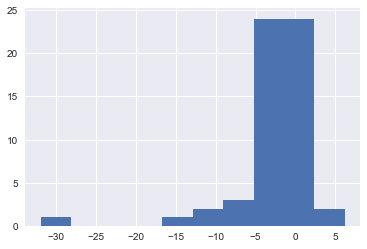

In [14]:
plt.hist(test_val['diff'])

In [15]:
print("Predicciones:")
print(test_val["Y_pred"].mean())
print(test_val["Y_pred"].max())
print(test_val["Y_pred"].min())

print("Diferencias:")
print(test_val["diff"].mean())
print(test_val["diff"].max())
print(test_val["diff"].min())

Predicciones:
30.1892032623291
55.87209
10.806675
Diferencias:
-2.7549570093532543
6.2016267107051775
-31.97243274482536


In [16]:
test_val['dist'] = df_test['dist']
test_val['time_seg'] = df_test['time_seg']
test_val['time_seg_pred'] = test_val['dist']/(test_val['Y_pred']/3.6)

In [24]:
import datetime

In [18]:
type(int(tiempo_real))

NameError: name 'tiempo_real' is not defined

In [ ]:
datetime.timedelta??

In [ ]:
type(tiempo_pred)

In [19]:
tiempo_real = test_val['time_seg'].sum()
tiempo_pred = test_val['time_seg_pred'].sum()
print('Tiempo Real: %s' %str(datetime.timedelta(seconds=int(tiempo_real))))
print('Tiempo Predicho: %s' %str(datetime.timedelta(seconds=tiempo_pred)))

Tiempo Real: 4:47:08
Tiempo Predicho: 4:22:59.299018


In [ ]:
test_val

In [21]:
print('Tiempo Real: %s' %str(datetime.timedelta(seconds=16242)))

Tiempo Real: 4:30:42


In [ ]:
test_val[(test_val["diff"]>8) | (test_val["diff"]<-10)]

In [11]:
pickle.dump(scalarX, open("Scaler.model", 'wb'))


model.save("TF_Tramos_2.model")
#Para cargar el modelo
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model